In [1]:
import torch
import numpy as np
import kaldiio
import torch
import torch.utils.data as data
import os
import matplotlib.pyplot as plt

import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

In [ ]:
from TrainAndTest.common_func import verification_test
from Process_Data.Datasets.KaldiDataset import ScriptVerifyDataset

In [2]:
script_dir = '/home/work2020/yangwenhao/project/SpeakerVerification-pytorch'
lstm_dir = '/home/work2020/yangwenhao/project/lstm_speaker_verification'

kwargs = {'num_workers': 8, 'pin_memory': False}


In [3]:
class xvector_Dataset(data.Dataset):
    def __init__(self, xvectors_dir, data_dir, feat_dim, loader=kaldiio.load_mat, domain=False,
                 label_dir=''):

        xvectors_scp = xvectors_dir + '/xvectors.scp'
        utt2spk = data_dir + '/utt2spk'

        for f in [xvectors_scp, utt2spk]:
            if not os.path.exists(f):
                raise FileExistsError(f)
            
        dataset = []
        spks = set([])
#         doms = set([])
        utt2spk_dict = {}
        with open(utt2spk, 'r') as u:
            all_cls_upath = u.readlines()
            for line in all_cls_upath:
                uid, spk = line.split()
                utt2spk_dict[uid] = spk
                spks.add(spk)
                    
        with open(xvectors_scp, 'r') as u:
            all_cls_upath = u.readlines()
            for line in all_cls_upath:
                uid, ufeat = line.split()
                dataset.append((uid, ufeat))
                
        print('==> There are {} speakers in Dataset.'.format(len(spks)))
        print('    There are {} utterances in Dataset'.format(len(dataset)))
#         if len(guide_label)>0:
#             print('    There are {} guide labels for egs in Dataset'.format(len(guide_label)))
#             assert len(guide_label) == len(dataset)

        self.dataset = dataset
        spks = list(spks)
        spks.sort()
        
        self.spk2idx = {spk: idx for idx,spk in enumerate(spks)}
        self.utt2spk = utt2spk_dict
#         self.guide_label = guide_label

        self.feat_dim = feat_dim
        self.loader = loader
#         self.transform = transform
        self.num_spks = len(spks)
#         self.num_doms = len(doms)
        self.domain = domain
#         self.chunk_size = []
#         self.batch_size = batch_size

    def __getitem__(self, idx):
        # time_s = time.time()
        # print('Starting loading...')
        uid, upath = self.dataset[idx]
        label = self.spk2idx[self.utt2spk[uid]]

        feature = self.loader(script_dir +'/'+ upath)
        return torch.FloatTensor(feature), label

    def __len__(self):
        return len(self.dataset)  # 返回一个epoch的采样数


In [4]:
class RNNPadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=0):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)
        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # pdb.set_trace()
        # pad according to max_len
        data = [x[0].float() for x in batch]
#         data = [x[:, :] for x in data]
        data_len = np.array([len(x) for x in data])
        sort_idx = np.argsort(-data_len)
        sort_data = [data[sort_idx[i]] for i in range(len(sort_idx))]

        labels = [x[1] for x in batch]
        sort_label = [labels[sort_idx[i]] for i in range(len(sort_idx))]
        # data.sort(key=lambda x: len(x), reverse=True)

        sort_label = torch.LongTensor(sort_label)

        data_length = [len(sq) for sq in sort_data]
        p_data = rnn_utils.pad_sequence(sort_data, batch_first=True, padding_value=0)
#         batch_x_pack = rnn_utils.pack_padded_sequence(p_data, data_length, batch_first=True)

        return p_data, sort_label, data_length


    def __call__(self, batch):
        return self.pad_collate(batch)

In [5]:
train_dir = xvector_Dataset(xvectors_dir=script_dir+'/Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/train',
                        data_dir=lstm_dir + '/data/cnceleb/egs/klfb/dev_fb40',
                        feat_dim=256,)

==> There are 800 speakers in Dataset.
    There are 111259 utterances in Dataset


In [6]:
for i in range(6):
    feature, label = train_dir[i]
    print(feature.shape, label)
#     print()

torch.Size([9, 256]) 0
torch.Size([5, 256]) 0
torch.Size([4, 256]) 0
torch.Size([15, 256]) 0
torch.Size([8, 256]) 0
torch.Size([8, 256]) 0


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


In [7]:
train_loader = torch.utils.data.DataLoader(train_dir, batch_size=16, collate_fn=RNNPadCollate(),
                                           shuffle=True, **kwargs)

In [8]:
# from Define_Model.Pooling import SelfAttentionPooling_v2

In [9]:
class SelfAttentionPooling_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttentionPooling_v2, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.attention_linear = nn.Linear(input_dim, self.hidden_dim)
        self.Tanh = nn.Tanh()
        self.attention_vector = nn.Linear(self.hidden_dim, input_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        :param x:   [batch, length, feat_dim] vector
        :return:   [batch, feat_dim] vector
        """
#         x_shape = x.shape
#         if len(x.shape) == 4:
#             x = x.transpose(1, 2)
#             x = x.reshape(x_shape[0], x_shape[2], -1)
#         assert x.shape[-1] == self.input_dim

        alpha = self.Tanh(self.attention_linear(x))
        alpha = self.softmax(self.attention_vector(alpha))
        mean = torch.sum(alpha * x, dim=1)

        return mean

In [29]:
ckp = torch.load(script_dir+'/'+'Data/checkpoint/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/checkpoint_60.pth')
print(list(ckp['state_dict'].keys())[-1])
cls_centers = ckp['state_dict']['classifier.W']
cls_centers = cls_centers.transpose(0,1)
print(cls_centers.shape)

classifier.W
torch.Size([800, 256])


tensor(0.2021, device='cuda:0')


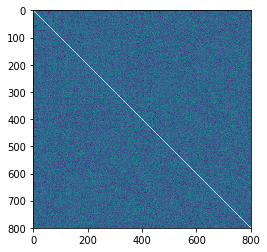

In [30]:
cls_centers_norm = torch.nn.functional.normalize(cls_centers, dim=1)

ccos_cnc = torch.matmul(cls_centers_norm,cls_centers_norm.transpose(0,1)).cpu()
plt.imshow(ccos_cnc)

print(cls_centers[0].norm(2))

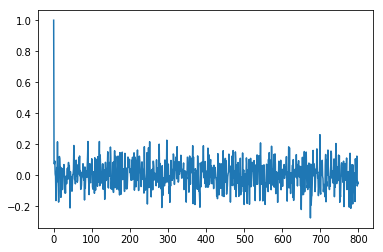

In [31]:
plt.plot(ccos_cnc[0])
# plt.plot(ccos[1])
# plt.plot(ccos[2])

In [32]:
ckp = torch.load(script_dir+'/'+'Data/checkpoint/ThinResNet18/vox1/klfb_egs_baseline/arcsoft_sgd_rop/chn32_Mean_basic_v2_downk5_none1_SAP2_dp125_alpha0_em256_wd5e4_var/checkpoint_50.pth')
print(list(ckp['state_dict'].keys())[-1])
cls_centers = ckp['state_dict']['classifier.W']
cls_centers = cls_centers.transpose(0,1)
print(cls_centers.shape)

classifier.W
torch.Size([1211, 256])


tensor(0.2616, device='cuda:0')


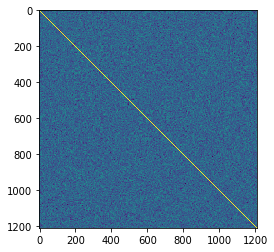

In [33]:
cls_centers_norm = torch.nn.functional.normalize(cls_centers, dim=1)

ccos_vox1 = torch.matmul(cls_centers_norm, cls_centers_norm.transpose(0,1)).cpu()
plt.imshow(ccos_vox1)

print(cls_centers[0].norm(2))

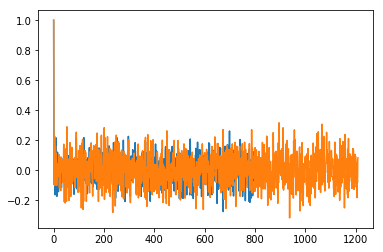

In [34]:
plt.plot(ccos_cnc[0], alpha=0.4)
plt.plot(ccos_vox1[0], alpha=0.4)

# plt.plot(ccos[1])
# plt.plot(ccos[2])

In [50]:
attention_model =  torch.nn.Sequential(
    SelfAttentionPooling_v2(input_dim=256, hidden_dim=128),
#     torch.nn.BatchNorm1d(256),
    )

ce = torch.nn.MSELoss()
attention_model = attention_model.cuda()

optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8,], gamma=0.1)

attention_model.train()
epochs = 12
total_loss = []
for e in range(epochs):
    epoch_loss = []
    for batch_idx, (data, label, data_length) in enumerate(train_loader):
        #print(data.data.shape)
        data = data.cuda()
        label = cls_centers[label].cuda()

        centers = attention_model(data)
        loss = ce(centers, label)
        epoch_loss.append(float(loss.item()))

        loss.backward()
        optimizer.step()  # update parameters of net
        optimizer.zero_grad()  # reset gradient

    print('Epoch %d loss: %f'%(e, np.mean(epoch_loss)))
            
    scheduler.step()
    total_loss.append(epoch_loss)
    
# plt.plot(total_loss)
    

Epoch 0 loss: 0.034852
Epoch 1 loss: 0.032279
Epoch 2 loss: 0.031433
Epoch 3 loss: 0.031527
Epoch 4 loss: 0.031711
Epoch 5 loss: 0.031005
Epoch 6 loss: 0.030880
Epoch 7 loss: 0.031244
Epoch 8 loss: 0.031113
Epoch 9 loss: 0.031544
Epoch 10 loss: 0.031368
Epoch 11 loss: 0.031220


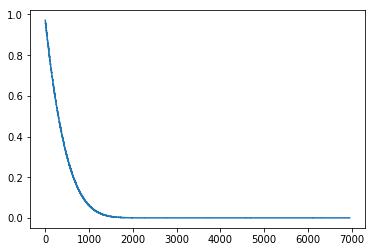

In [28]:
plt.plot(total_loss)

In [51]:
with open(script_dir+'/'+'Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/test/xvectors.scp', 'r') as f:
    attention_model.eval()
    dest_dir = 'Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/test_centers/'
    with kaldiio.WriteHelper('ark,scp:%s,%s'% (script_dir+'/'+dest_dir+'xvectors.ark', script_dir+'/'+dest_dir+'xvectors.scp'), compression_method=None) as w:                  
        for line in f.readlines():
            uid,upath = line.split()
            uvectors = kaldiio.load_mat(script_dir + '/'+upath)
            uvectors = torch.FloatTensor(uvectors).cuda()
            center = attention_model(uvectors.unsqueeze(0))
#             print(center.shape)
            w(uid, center.detach().cpu().squeeze().numpy())  

In [52]:
test_centers = 'Data/xvector/ThinResNet18/cnceleb/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_basic_downk3_none1_SAP2_dp01_alpha0_em256_wd5e4_var/cnceleb_test_var/xvectors_b/epoch_60/test_centers'
test_dir = ScriptVerifyDataset(dir=lstm_dir+'/data/cnceleb/klfb/test_fb40', 
                               trials_file='trials', 
                               xvectors_dir=script_dir+'/'+test_centers,
                               loader=kaldiio.load_mat)
test_loader = torch.utils.data.DataLoader(test_dir, batch_size=16 * 64, shuffle=False, **kwargs)

eer, eer_threshold, mindcf_01, mindcf_001 = verification_test(test_loader, dist_type='cos', 
                  log_interval=100, xvector_dir=script_dir+'/'+test_centers, epoch=60)

print(eer)

0.13903683976919662


In [49]:
# 1 epoch
# 0.1349312028406569

# 15 epoech
# 0.18203506435863293'

# 15 epoech remove bn
# 0.13920328450954284

# 12 epoech remove bn
# 0.13903683976919662

0.13920328450954284
